# Install Dependencies

In [3]:
%%capture
%pip install torch_geometric torch pandas wandb

In [4]:
import os
import shutil

# Create a directory in your Google Drive
workdir = os.getcwd() + "/DGT"

# # Remove and recreate directory
# if os.path.exists(workdir):
#     shutil.rmtree(workdir)
# os.makedirs(workdir)

# Dataset Construction

## Download Dataset

In [5]:
# Clone the repository to download the S&P500 stock prices, precomputed correlation matrcies,
# along with trained model weights for ease of evaluation
# !git clone https://github.com/AlienKevin/sp500.git

# import shutil
# import os

# repo_name = "sp500"
# for file_name in os.listdir(repo_name):
#     shutil.move(os.path.join(repo_name, file_name), workdir)

# # Remove the cloned repository folder
# shutil.rmtree(repo_name)

## Exploratory Data Analysis Shows Superiority of Mutual Information in Capturing Interstock Relationships

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot the 3 most correlated stocks to the target_stock based on corr_name with scope corr_scope
def plot_most_correlated_stocks(target_stock, corr_name, corr_scope):
    df = pd.read_csv(f'{workdir}/sp500.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    target_index = df.columns.get_loc(target_stock)

    corr = np.loadtxt(f'{workdir}/{corr_name}/{corr_scope}.csv', delimiter=',')

    top_3_correlated_indices = corr[target_index].argsort()[-4:][::-1]
    top_3_correlated_stocks = df.columns[top_3_correlated_indices]

    plt.clf()
    plt.figure(figsize=(12, 6))
    plt.style.use('default')

    for stock in top_3_correlated_stocks:
        if corr_scope.startswith('global'):
            # Plot the entire duration of the dataset for global correlations
            plt.plot(df.index, df[stock], label=stock)
        else:
            # Only plot the time window corresponding to the local correlations
            num_days_in_quarter = 64
            quarter_index = int(corr_scope.split('_')[-1])
            quarter_start_index = quarter_index * num_days_in_quarter
            quarter_end_index = (quarter_index + 1) * num_days_in_quarter
            print('Quarter Start date', df.index[quarter_start_index])
            print('Quarter End date', df.index[quarter_end_index])
            quarter_df = df.iloc[quarter_start_index:quarter_end_index]
            plt.plot(quarter_df.index, quarter_df[stock], label=stock)

    plt.title(f"Top 3 Correlated Stocks with {top_3_correlated_stocks[0]} using {'Global' if corr_scope.startswith('global') else 'Local'} {'Pearson' if corr_name == 'pcc' else 'Mutual Information'}: {', '.join(top_3_correlated_stocks[1:])}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


## Global Mutual Information Captures Shared Trends Well

<Figure size 640x480 with 0 Axes>

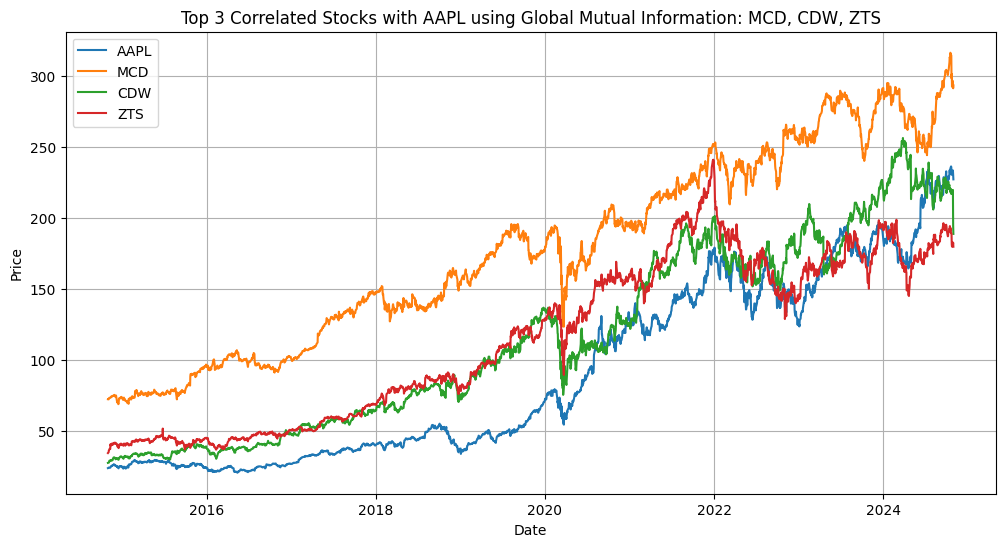

In [7]:
plot_most_correlated_stocks('AAPL', 'mi', 'global_corr')

## Global Pearson Struggles with Nonlinearity in the Market

<Figure size 640x480 with 0 Axes>

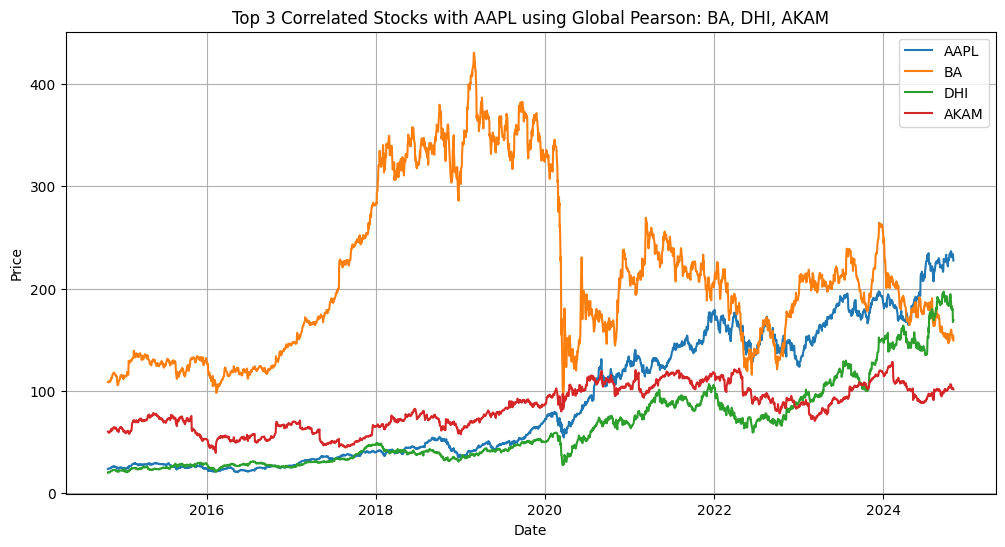

In [8]:
plot_most_correlated_stocks('AAPL', 'pcc', 'global_corr')

## Mutual Information and Pearson Perform Similarly Well on a Local Scope (the Length of 1 Fiscal Quarter)

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

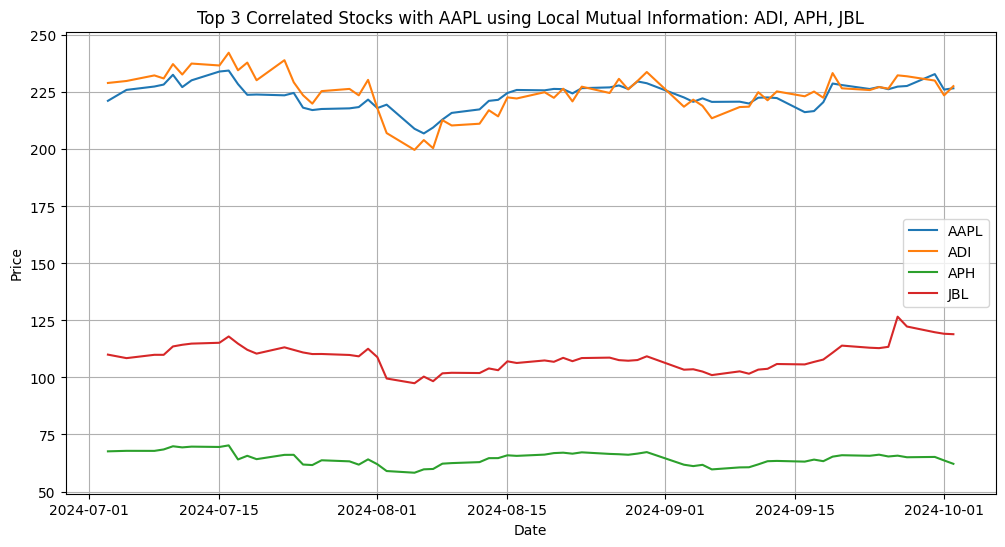

In [9]:
plot_most_correlated_stocks('AAPL', 'mi', 'local_corr_38')

Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00
Quarter Start date 2024-07-03 00:00:00+00:00
Quarter End date 2024-10-03 00:00:00+00:00


<Figure size 640x480 with 0 Axes>

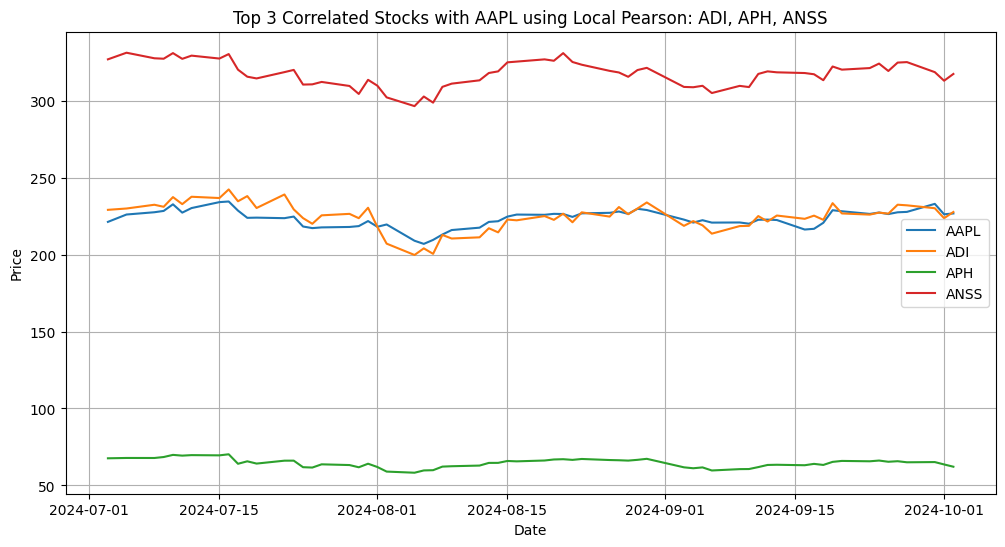

In [10]:
plot_most_correlated_stocks('AAPL', 'pcc', 'local_corr_38')

## Construct Temporal PyG Dataset

In [11]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/dynamic_graph_temporal_signal.html

from typing import Sequence, Union
import numpy as np
import torch
from torch_geometric.data import Data


Edge_Indices = Sequence[Union[np.ndarray, None]]
Edge_Weights = Sequence[Union[np.ndarray, None]]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class DynamicGraphTemporalSignal(object):
    r"""A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Edge_Indices,
        edge_weights: Edge_Weights,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

/home/chokellaaaaaaa/epita/s9/Stock-DiffTransformer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Copied from PyG temporal rather than imported because the library has dependency issues with PyG
# https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/signal/static_graph_temporal_signal.html#StaticGraphTemporalSignal
import torch
import numpy as np
from typing import Sequence, Union
from torch_geometric.data import Data


Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = Sequence[Union[np.ndarray, None]]
Targets = Sequence[Union[np.ndarray, None]]
Additional_Features = Sequence[np.ndarray]

class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_index: Edge_Index,
        edge_weight: Edge_Weight,
        features: Node_Features,
        targets: Targets,
        **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

In [13]:
import numpy as np
import pandas as pd
import torch
from typing import Union
import glob
from natsort import natsorted
import random

# Fix random seed for ease of reproduction
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# Dataset loader for SP500 stock prices
class SP500CorrelationsDatasetLoader(object):
    def __init__(self, corr_name, corr_scope):
        self._read_csv(corr_name, corr_scope)

    # Load a global correlation under the name corr_name
    def _load_global_corr(self, corr_name):
        return np.loadtxt(f'{workdir}/{corr_name}/global_corr.csv', delimiter=',')

    # Load a local correlation under the name corr_name
    def _load_local_corrs(self, corr_name):
        _correlation_matrices = []
        corr_files = natsorted(glob.glob(f'{workdir}/{corr_name}/local_corr_*.csv'))
        for corr_file in corr_files:
            matrix = np.loadtxt(corr_file, delimiter=',')
            _correlation_matrices.append(matrix)
        return _correlation_matrices

    # Helper function for reading a correlation with type corr_name and scope corr_scope from CSV file
    def _read_csv(self, corr_name, corr_scope):
        match corr_scope:
            case 'global':
                self._correlation_matrices = [self._load_global_corr(corr_name)]
            case 'local':
                self._correlation_matrices = self._load_local_corrs(corr_name)
            case 'dual':
                # Stack global and local correlation matrices for dual correlation
                global_corr = self._load_global_corr(corr_name)
                self._correlation_matrices = [np.stack((global_corr, local_corr), axis=-1) for local_corr in self._load_local_corrs(corr_name)]
            case None:
                # None uses identity matrix as correlation
                # Infer dimension from a global correlation matrix
                global_corr = self._load_global_corr('pcc')
                self._correlation_matrices = [np.eye(global_corr.shape[0], global_corr.shape[1])]

        if corr_name == 'mi':
            # Normalize MI to [0, 1]
            max_mi = 0
            for matrix in self._correlation_matrices:
                max_mi = max(np.max(matrix), max_mi)
                # MI shouldn't be negative
                matrix[matrix < 0] = 0
            for matrix in self._correlation_matrices:
                matrix = matrix / max_mi

        df = pd.read_csv(f'{workdir}/sp500.csv')
        df = df.set_index('Date')
        data = torch.from_numpy(df.to_numpy()).to(torch.float32)

        # Round data size to nearest multiple of batch_size
        self.days_in_quarter = 64
        num_quarters = data.size(0) // self.days_in_quarter
        num_days = num_quarters * self.days_in_quarter
        data = data[:num_days]

        # z-score normalization with training data following GERU
        train_days = int(0.8 * num_quarters) * self.days_in_quarter
        data = (data - data[:train_days].mean(dim=0)) / data[:train_days].std(dim=0)
        data = data.numpy()

        data = data[..., np.newaxis]

        assert(not np.any(np.isnan(data)))
        self._dataset = data

    def _get_edges(self, times, overlap):
        # Construct a fully-connected graph
        def helper(corr_index):
            return np.array(np.ones(self._correlation_matrices[corr_index].shape[:2]).nonzero())

        if len(self._correlation_matrices) == 1:
            _edges = helper(0)
        else:
            _edges = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edges.append(
                    helper(corr_index)
                )
        return _edges

    def _get_edge_weights(self, times, overlap):
        # Edge weights are the correlations between stocks
        def helper(corr_index):
            w = self._correlation_matrices[corr_index]
            # Flatten the first two dimensions
            return w.reshape((w.shape[0] * w.shape[1],) + w.shape[2:])

        if len(self._correlation_matrices) == 1:
            _edge_weights = helper(0)
        else:
            _edge_weights = []
            for time in range(0, self._dataset.shape[0] - self.batch_size, overlap):
                if not time in times:
                    continue
                corr_index = max(0, time // self.days_in_quarter - 1)
                _edge_weights.append(
                    helper(corr_index)
                )
        return _edge_weights

    def _get_targets_and_features(self, times, overlap, predict_all):
        # Given previous batch_size stock prices...
        features = [
            self._dataset[i : i + self.batch_size, :]
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        # predict next-day stock prices
        targets = [
            (self._dataset[i+1 : i + self.batch_size+1, :, 0]).T if predict_all else (self._dataset[i + self.batch_size, :, 0]).T
            for i in range(0, self._dataset.shape[0] - self.batch_size, overlap)
            if i in times
        ]
        return features, targets

    def get_dataset(self, batch_size, split) -> Union[StaticGraphTemporalSignal, DynamicGraphTemporalSignal]:
        # Returning the data iterator where the train is designed for many-to-many predictions (each day predict next day's price)
        # while the validation and test are many-to-one predictions (many past days predict tomorrow's price)

        self.batch_size = batch_size

        total_times = list(range(0, self._dataset.shape[0] - self.batch_size, self.batch_size))

        # We do a 8-1-1 split for train-validation-test. Since the test set is one year apart from training,
        # It is much more challenging to predict.
        if split == 'train':
            times = list(range(total_times[int(len(total_times) * 0)], total_times[int(len(total_times) * 0.8)]))
            overlap = self.batch_size
            predict_all = True
        elif split == 'val':
            times = list(range(total_times[int(len(total_times) * 0.8)], total_times[int(len(total_times) * 0.9)]))
            overlap = 1
            predict_all = False
        elif split == 'test':
            times = list(range(total_times[int(len(total_times) * 0.9)], total_times[-1] + self.batch_size))
            overlap = 1
            predict_all = False
        else:
            raise ValueError(f'Invalid split name: {split}')

        _edges = self._get_edges(times, overlap)
        _edge_weights = self._get_edge_weights(times, overlap)
        features, targets = self._get_targets_and_features(times, overlap, predict_all)
        dataset = (DynamicGraphTemporalSignal if type(_edges) == list else StaticGraphTemporalSignal)(
            _edges, _edge_weights, features, targets
        )
        return dataset

In [14]:
# Helper function to get the dataset for a correlation
def get_dataset(corr_name, corr_scope):
    loader = SP500CorrelationsDatasetLoader(corr_name=corr_name, corr_scope=corr_scope)

    lag_size = 64
    # Train dataset has double the batch_size because it's trained under many-to-many prediction.
    # During test time, the model is used for many-to-one prediction given batch_size previous days.
    # Hence, we need to have a larger training batch_size than the lag_size during test.
    train_dataset = loader.get_dataset(batch_size=lag_size * 2, split='train')
    val_dataset = loader.get_dataset(batch_size=lag_size, split='val')
    test_dataset = loader.get_dataset(batch_size=lag_size, split='test')

    train_samples = list(train_dataset)
    val_samples = list(val_dataset)
    test_samples = list(test_dataset)

    return {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'test_samples': test_samples,
    }

# Differential Graph Transformer

In [15]:
# Adapted from reference implementation of Differential Transformer, included an optional A input to MultiheadDiffAttn.forward()
# https://github.com/microsoft/unilm/blob/master/Diff-Transformer/multihead_diffattn.py

import math
import torch
import torch.nn.functional as F
from torch import nn

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, elementwise_affine=True):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(dim))
        else:
            self.register_parameter('weight', None)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        if self.weight is not None:
            output = output * self.weight
        return output

    def extra_repr(self) -> str:
        return f'dim={self.dim}, eps={self.eps}, elementwise_affine={self.elementwise_affine}'


def init_method(tensor, **kwargs):
    nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=1, repeats=n_rep)"""
    bs, n_kv_heads, slen, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, None, :, :]
        .expand(bs, n_kv_heads, n_rep, slen, head_dim)
        .reshape(bs, n_kv_heads * n_rep, slen, head_dim)
    )

def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)


# Differential Graph Attention with multiple heads
class MultiheadDiffAttn(nn.Module):
    def __init__(
        self,
        embed_dim,
        depth,
        num_heads,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        # num_heads set to half of Transformer's #heads
        self.num_heads = num_heads
        self.num_kv_heads = num_heads
        self.n_rep = self.num_heads // self.num_kv_heads

        self.head_dim = embed_dim // num_heads // 2
        self.scaling = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim // self.n_rep, bias=False)

        self.lambda_init = lambda_init_fn(depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0,std=0.1))

        self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)

    def forward(
        self,
        x,
        A=None,
        attn_mask=None,
    ):
        bsz, tgt_len, embed_dim = x.size()
        src_len = tgt_len

        # Project input x into query, key, and value
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(bsz, tgt_len, 2 * self.num_heads, self.head_dim)
        k = k.view(bsz, src_len, 2 * self.num_kv_heads, self.head_dim)
        v = v.view(bsz, src_len, self.num_kv_heads, 2 * self.head_dim)

        q = q.transpose(1, 2)
        k = repeat_kv(k.transpose(1, 2), self.n_rep)
        v = repeat_kv(v.transpose(1, 2), self.n_rep)
        q *= self.scaling

        # Compute attention weights by multiplying query and key
        attn_weights = torch.matmul(q, k.transpose(-1, -2))
        attn_weights = torch.nan_to_num(attn_weights)
        # Apply attention mask
        if attn_mask is not None:
            attn_weights += attn_mask
        # Calculate attention scores using softmax
        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
            attn_weights
        )

        # Calculate the lambda used for differential attention
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(q)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(q)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init

        # Optionally condition the differential attention on a graph prior A
        attn_weights = attn_weights.view(bsz, self.num_heads, 2, tgt_len, src_len)
        attn_weights = attn_weights[:, :, 0] * (1 if A is None else A) - lambda_full * attn_weights[:, :, 1]

        # Compute output embeddings by mixing values based on their attention scores
        attn = torch.matmul(attn_weights, v)
        attn = self.subln(attn)
        attn = attn * (1 - self.lambda_init)
        attn = attn.transpose(1, 2).reshape(bsz, tgt_len, self.num_heads * 2 * self.head_dim)
        
        # Store the last attention weights for visualization
        self.last_attn = attn_weights.detach()
        
        return (attn, attn_weights)


In [16]:
import torch
import torch.nn as nn
from torch_geometric.utils import to_dense_adj

# A normal feedforward layer
class FeedForward(nn.Module):
    def __init__(self, hidden_size, expand_ratio, dropout):
        super(FeedForward, self).__init__()
        self.linear = nn.Linear(hidden_size, hidden_size * expand_ratio)
        self.linear2 = nn.Linear(hidden_size * expand_ratio, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

# Wrapper code for MultiheadDiffAttn with layer norm and feedforward after the attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, expand_ratio, dropout):
        super().__init__()
        self.mha = MultiheadDiffAttn(embed_dim=d_model, num_heads=num_heads, depth=0)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(hidden_size=d_model, expand_ratio=expand_ratio, dropout=dropout)

    def forward(self, x, A=None, attn_mask=None, need_weights=False):
        x1, attn_weights = self.mha(x, A, attn_mask=attn_mask)
        x = self.ln2(self.ffn(x1) + x1)
        if need_weights:
            return (x, attn_weights)
        else:
            return x

# Differential Graph Transformer = temporal attention + spatial attention
# Spatial attention may optionally receive an adjacency matrix for conditioning.
class DGT(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, num_heads=2, num_layers=2, expand_ratio=1, dropout=0.1, T=128, N=472, use_spatial=True):
        super().__init__()
        self.T = T
        self.N = N
        self.d_model = out_channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.input_proj = nn.Linear(in_channels, out_channels)
        self.time_embedding = nn.Embedding(T, out_channels)
        self.stock_embedding = nn.Embedding(N, out_channels)
        self.use_spatial = use_spatial
        if use_spatial:
            self.spatial_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])
        self.temporal_attns = nn.ModuleList([Attention(out_channels, num_heads, expand_ratio, dropout) for _ in range(num_layers)])

    def forward(self, x, edge_index, edge_weight, need_weights=False):
        N, T, D = x.size()
        assert(D == 1)
        assert(T <= self.T and N == self.N)

        # Compute initial node embedding for the graph transformer
        # Node embedding incorporates current stock prices, stock embeddings, and time embeddings.
        x = x.permute(1, 0, 2) # T, N, D
        x = self.input_proj(x)
        stock_embs = self.stock_embedding(torch.arange(N).unsqueeze(0).expand(T, N).to(x.device))
        x += stock_embs
        time_embs = self.time_embedding(torch.arange(T).unsqueeze(0).expand(N, T).to(x.device))
        x += time_embs.permute(1, 0, 2) # T, N, D

        x = x.permute(1, 0, 2) # N, T, D

        # Iterate through each layer of DGT
        for i in range(self.num_layers):
            # First apply temporal attention to learn temporal dependencies
            temporal_causal_mask = torch.triu(
                torch.zeros([T, T])
                    .float()
                    .fill_(float("-inf")),
                    1,
                ).expand(N, self.num_heads*2, T, T).to(x.device)
            x = self.temporal_attns[i](x, attn_mask=temporal_causal_mask, need_weights=need_weights) + x

            # Next apply spatial attention (aka differential graph attention) to learn interstock relations
            if self.use_spatial:
                x = x.permute(1, 0, 2) # T, N, D
                A = to_dense_adj(edge_index, edge_attr=edge_weight)
                # Encountered more than one adjacency matrices, e.g. dual correlations
                if len(A.size()) == 4:
                    A = A.reshape(A.size(-1), A.size(1), A.size(2))
                x = self.spatial_attns[i](x, A, need_weights=need_weights) + x
                x = x.permute(1, 0, 2) # N, T, D

        return x

# GRU Baseline

In [17]:
# Gated Recurrent Unit baseline for comparison
class GRU(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_layers: int):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=in_channels, hidden_size=out_channels, num_layers=num_layers, batch_first=True)

    def forward(
        self,
        x: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        outputs, _ = self.rnn(x)
        return outputs

# Driver

In [18]:
import torch
import torch.nn.functional as F

# Common drive for all models
class Driver(torch.nn.Module):
    def __init__(self, gnn, corr_name, corr_scope, node_features, hidden_size=32, **kwargs):
        super(Driver, self).__init__()
        self.recurrent = gnn(in_channels=node_features, out_channels=hidden_size, **kwargs)
        self.linear = torch.nn.Linear(hidden_size, 1)
        self.corr_name = corr_name
        self.corr_scope = corr_scope

    # Run on the provided graph (specified with edge_index and edge_weight) and temporal signal x (past stock prices)
    def forward(self, x, edge_index, edge_weight, hidden=None):
        device = self.model_device()
        if hidden is None:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device))
        else:
            outputs = self.recurrent(x.to(device), edge_index.to(device), edge_weight.to(device), hidden)
        # Use final linear layer for regression
        return self.linear(F.relu(outputs)), outputs

    # Get the model name for display and saving model weights
    def model_name(self):
        arch = self.model_arch()
        if arch == 'GRU':
            return f'{arch}'
        elif arch == 'DGT':
            name = f'{arch}{"" if self.recurrent.use_spatial else "_no_spatial"}'
            if self.corr_scope is not None:
                name += f'_{self.corr_name}_{self.corr_scope}'
            return name

    # Get the model architecture for display
    def model_arch(self):
        return self.recurrent.__class__.__name__

    # Set the device for the model
    def model_device(self):
        return torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Evaluation on Price Regression with RMSE and MAE

In [19]:
import math

# Root Mean Squared Error for evaluation
def rmse(y_hat, y):
    return math.sqrt(F.mse_loss(y_hat, y).item())

# Mean Absolute Error for evaluation
def mae(y_hat, y):
    return F.l1_loss(y_hat, y).item()

In [20]:
import wandb

# Helper function for inference
def infer(model, snapshot):
    X = snapshot.x
    batch_y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr)
    return batch_y_hats[:, -1]

# Evaluate the model on eval_dataset and calculate RMSE and MAE
def eval(model, eval_dataset):
    model.eval()
    with torch.no_grad():
        y_hats = list(map(lambda snapshot: infer(model, snapshot), eval_dataset))
        ys = [snapshot.y for snapshot in eval_dataset]
        y_hats = torch.stack(y_hats, dim=0).squeeze().to(model.model_device())
        ys = torch.stack(ys, dim=0).to(model.model_device())
        eval_rmse = rmse(y_hats, ys)
        eval_mae = mae(y_hats, ys)
        return {'y_hats': y_hats, 'ys': ys, 'rmse': eval_rmse, 'mae': eval_mae}

In [21]:
# Helper function to get a model based on the input configs, optionally loads the weight if load_weights=True
def get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False):
    node_features = 1
    if gnn == DGT:
        model = Driver(gnn, corr_name, corr_scope, node_features, num_heads=2, use_spatial=use_spatial)
    elif gnn == GRU:
        # GRU does not support any correlation
        if corr_name != None or corr_scope != None:
            return None
        model = Driver(gnn, None, None, node_features, num_layers=2)
    if load_weights:
        model.load_state_dict(torch.load(f'{workdir}/models/{model.model_name()}_lr_{lr}.pth', weights_only=True))
    return model.to(model.model_device())


# Training

**Note: Training took 3 hours on a T4. You can skip the following code block and run the evaluations directly as our checkpoints are already downloaded.** In case you are training, you can also set `track_with_wandb` to `False` if you don't want to track with Weights and Biases.

In [22]:
import wandb
import os

# Train a model with the input configs on train_samples for num_epochs under the learning rate lr
# You can pass track_with_wandb=True to trace the entire training process with Weights and Biases
def train(gnn, use_spatial, corr_name, corr_scope, train_samples, val_samples, num_epochs, lr, track_with_wandb):
    os.makedirs(f'{workdir}/models', exist_ok=True)

    model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_rmse = float('inf')
    best_val_mae = float('inf')
    eval_per_epoch = 10

    if track_with_wandb:
        wandb_run = wandb.init(project="cs224w-stock-market-prediction",
                   name=f'{model.model_name()}_lr_{lr}',
                   config={
                       "corr_name": corr_name,
                       "corr_scope": corr_scope,
                       "learning_rate": lr,
                       "epochs": num_epochs,
                       "architecture": gnn.__name__,
                       "use_spatial": use_spatial,
                   },
                   reinit=True,
                   )

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, snapshot in enumerate(train_samples):
            optimizer.zero_grad()
            X = snapshot.x
            y_hats, _ = model(X.transpose(0, 1), snapshot.edge_index, snapshot.edge_attr, hidden=None)
            loss = F.mse_loss(y_hats.squeeze(), snapshot.y.to(model.model_device()))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            if track_with_wandb:
                wandb.log({"epoch": epoch, "step": step, "train/loss": loss.item() })
        train_loss /= len(train_samples)

        if epoch % eval_per_epoch == 0 or epoch == num_epochs - 1:
            result = eval(model, val_samples)
            val_rmse = result['rmse']
            val_mae = result['mae']
            print(f'{model.model_name()} epoch {epoch} val/rmse: {val_rmse} val/mae: {val_mae}')
            if track_with_wandb:
                wandb.log({"epoch": epoch, "val/rmse": val_rmse, "val/mae": val_mae })
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_val_mae = val_mae
                torch.save(model.state_dict(), f'{workdir}/models/{model.model_name()}_lr_{lr}.pth')
    if track_with_wandb:
        wandb.log({"val/best_rmse": best_val_rmse, "val/best_mae": best_val_mae })
        return wandb_run


def run(args):
    config, num_epochs, track_with_wandb = args
    gnn, use_spatial, corr_name, corr_scope = config
    dataset = get_dataset(corr_name, corr_scope)
    # Do a grid search over learning rate. We found that models are sensitive to lr so we need to try different options.
    for lr in [0.01, 0.1]:
        wandb_run = train(gnn, use_spatial, corr_name, corr_scope, dataset['train_samples'], dataset['val_samples'], num_epochs, lr, track_with_wandb)
        # Test
        best_model = get_model(gnn, use_spatial, corr_name, corr_scope, lr, load_weights=True)
        result = eval(best_model, dataset['test_samples'])
        test_rmse = result['rmse']
        test_mae = result['mae']
        print(f'{best_model.model_name()} lr: {lr} test/rmse: {test_rmse} test/mae: {test_mae}')
        if track_with_wandb:
            wandb.log({"test/rmse": test_rmse, "test/mae": test_mae })
            wandb_run.finish()

# List all the model variants for the experiment
model_configs = [(GRU, False, None, None),
                 (DGT, False, None, None),
                 (DGT, True, None, None),
                 (DGT, True, 'mi', 'global'),
                 (DGT, True, 'mi', 'local'),
                 (DGT, True, 'mi', 'dual'),
                 (DGT, True, 'pcc', 'global'),
                 (DGT, True, 'pcc', 'local'),
                 (DGT, True, 'pcc', 'dual'),
                 ]

# num_epochs = 100
# track_with_wandb = True

# if track_with_wandb:
#     wandb.login()

# _ = list(map(run, [(config, num_epochs, track_with_wandb) for config in model_configs]))

# Results Show Local Mutual Information Performs the Best, Followed by Dual Pearson

In [23]:
# Function to test a bunch of models given by model_configs on the test set
def test(model_configs):
    results = {}
    for config in model_configs:
        (gnn, use_spatial, corr_name, corr_scope, lr) = config
        eval_dataset = get_dataset(corr_name, corr_scope)['test_samples']
        model = get_model(gnn, use_spatial, corr_name, corr_scope, lr=lr, load_weights=True)
        if model is None:
            continue
        results[config] = eval(model=model, eval_dataset=eval_dataset)
    return results

# Test each model under its best learning rate based on validation performance
model_configs = [(GRU, False, None, None, 0.01),
                 (DGT, False, None, None, 0.1),
                 (DGT, True, None, None, 0.01),
                 (DGT, True, 'mi', 'global', 0.01),
                 (DGT, True, 'mi', 'local', 0.01),
                 (DGT, True, 'mi', 'dual', 0.01),
                 (DGT, True, 'pcc', 'global', 0.01),
                 (DGT, True, 'pcc', 'local', 0.01),
                 (DGT, True, 'pcc', 'dual', 0.01),
                 ]
test_results = test(model_configs)

In [24]:
# Test the models and show a table of results
test_results_df = []
for config, result in test_results.items():
    (arch, use_spatial, corr_name, corr_scope, lr) = config
    test_results_df.append({'Architecture': arch.__name__,
                            'Use Spatial': use_spatial,
                            'Correlation': corr_name,
                            'Scope': corr_scope,
                            'RMSE': result['rmse'],
                            'MAE': result['mae']})

test_results_df = pd.DataFrame(test_results_df)
test_results_df = test_results_df.sort_values(by='RMSE', ascending=False)
print('Test results sorted in descending RMSE (Lower the better)')
display(test_results_df)

Test results sorted in descending RMSE (Lower the better)


,Architecture,Use Spatial,Correlation,Scope,RMSE,MAE
0,GRU,False,None,None,3.116608,0.407619
2,DGT,True,None,None,1.473705,0.292516
6,DGT,True,pcc,global,0.643023,0.147955
3,DGT,True,mi,global,0.465103,0.114918
1,DGT,False,None,None,0.432899,0.181658
4,DGT,True,mi,local,0.324191,0.133980
8,DGT,True,pcc,dual,0.296782,0.157395
7,DGT,True,pcc,local,0.294103,0.086751
5,DGT,True,mi,dual,0.259889,0.099287


# Visualize Results

In [25]:
df = pd.read_csv(f'{workdir}/sp500.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
stock_names = df.columns
stock_lookup = {name: i for i, name in enumerate(stock_names)}

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

# Plot regression results on test set
def plot_regression(configs, labels, fig_name, stock_name, test_results):
    stock_index = stock_lookup[stock_name]
    plt.clf()
    plt.figure(figsize=(10, 6))
    colors = [(0.650, 0.120, 0.240, 0.6),  # red
              (0.122, 0.467, 0.706, 0.6), # blue
              (1.000, 0.498, 0.055), # orange
              (0.580, 0.403, 0.741, 0.6), # purple
              ]
    plt.rc('axes', prop_cycle=cycler('color', colors))

    for config, label in zip(configs, labels):
        result = test_results[config]
        ys = torch.tensor([y[stock_index] for y in result['ys'].cpu()])
        y_hats = torch.tensor([y_hat[stock_index] for y_hat in result['y_hats'].cpu()])
        x = np.array(range(len(ys)))
        plt.plot(x, y_hats, label=label, linewidth=1)

    plt.plot(x, ys, label="Real", color='green')
    plt.legend(fontsize=14)
    plt.title(f'Predicted vs Real {stock_name} Stock Price on Test', fontsize=20)
    plt.xlabel('Days', fontsize=16)
    plt.ylabel('Normalized Price', fontsize=16)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.savefig(fig_name)
    plt.show()


## Local Mutual Information Outperforms Global and Dual

<Figure size 640x480 with 0 Axes>

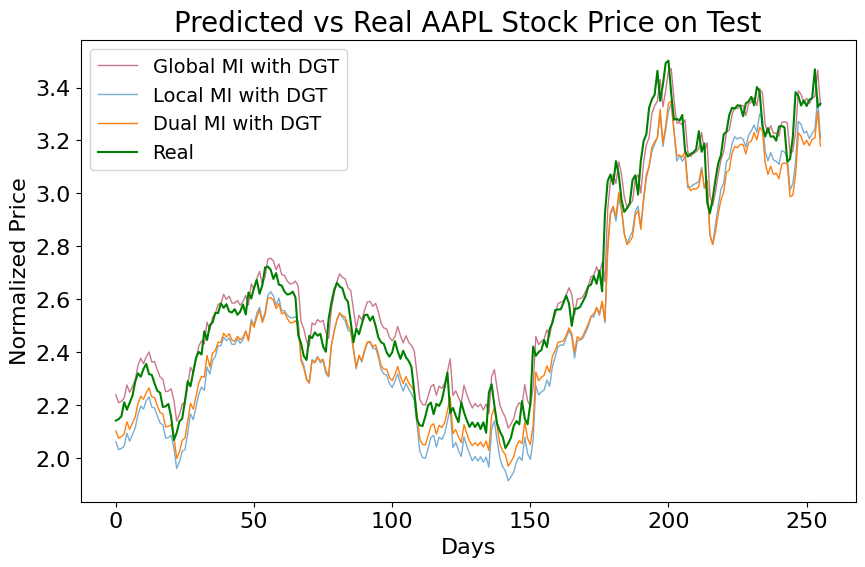

In [27]:
plot_regression([(DGT, True, 'mi', 'global', 0.01),
                (DGT, True, 'mi', 'local', 0.01),
                (DGT, True, 'mi', 'dual', 0.01)
                ],
                ['Global MI with DGT', 'Local MI with DGT', 'Dual MI with DGT'],
                stock_name='AAPL', fig_name=f'{workdir}/sp500_AAPL_MI.png', test_results=test_results)

## Dual Pearson Outperforms Global and Local

<Figure size 640x480 with 0 Axes>

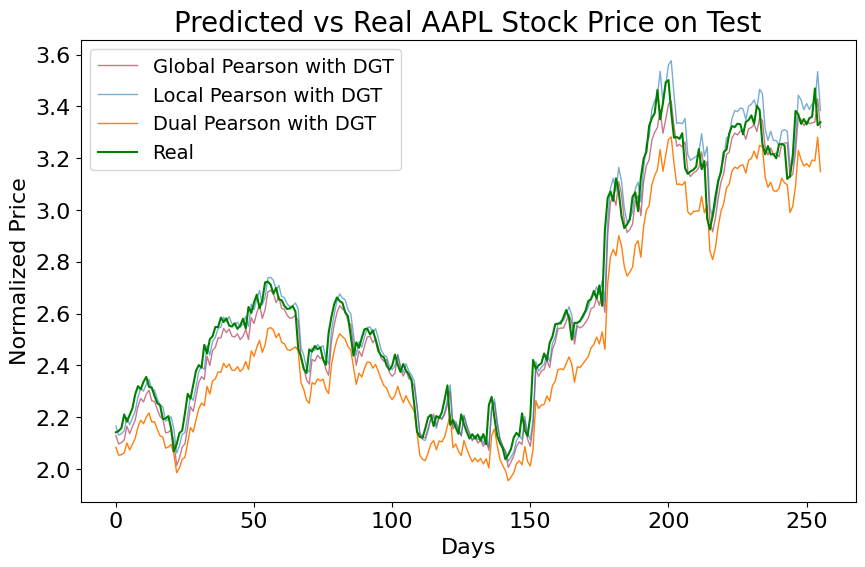

In [28]:
plot_regression([(DGT, True, 'pcc', 'global', 0.01),
                (DGT, True, 'pcc', 'local', 0.01),
                (DGT, True, 'pcc', 'dual', 0.01)],
                ['Global Pearson with DGT', 'Local Pearson with DGT', 'Dual Pearson with DGT'],
                stock_name='AAPL', fig_name=f'{workdir}/sp500_AAPL_PCC.png', test_results=test_results)

# Risk Management

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP GLOBAL (A exécuter une seule fois)
# ==========================================

# --- A. Récupération des stats de normalisation (Train Set) ---
df_raw = pd.read_csv(f'{workdir}/sp500.csv').set_index('Date')
days_in_quarter = 64
num_quarters = len(df_raw) // days_in_quarter
train_days = int(0.8 * num_quarters) * days_in_quarter

# On sauvegarde ces constantes pour le dénormaliseur
TRAIN_MEAN = df_raw.iloc[:train_days].mean().values
TRAIN_STD = df_raw.iloc[:train_days].std().values
COLS = df_raw.columns

🛡️ Lancement du Backtest SÉCURISÉ pour : (<class '__main__.DGT'>, False, None, None, 0.1)
Rendement Annuel : 29.82%
Volatilité       : 12.92%
Sharpe Ratio     : 2.31
Max Drawdown     : -7.22%


/tmp/ipykernel_36467/2774182298.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')


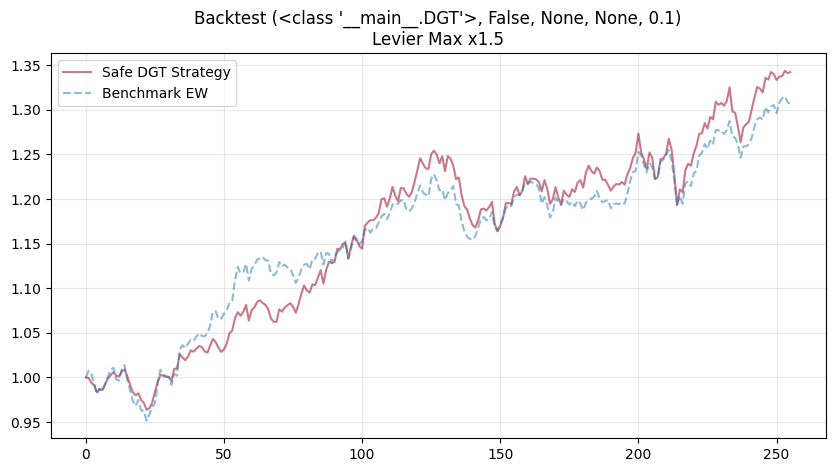

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_model_safe(model_config, result, vol_window=60, target_vol=0.15, max_leverage=1.5, max_position=0.10):
    print(f"🛡️ Lancement du Backtest SÉCURISÉ pour : {model_config}")
    
    # --- A. Dénormalisation (Utilisation des globales) ---
    # Plus besoin de relire le CSV ici
    
    z_pred = result['y_hats'].cpu().numpy()
    z_true = result['ys'].cpu().numpy()
    
    # Utilisation directe des constantes globales définies plus haut
    price_pred = pd.DataFrame(z_pred * TRAIN_STD + TRAIN_MEAN, columns=COLS)
    price_true = pd.DataFrame(z_true * TRAIN_STD + TRAIN_MEAN, columns=COLS)
    
    # --- B. Calcul des Signaux ---
    real_returns = price_true.pct_change().fillna(0.0)
    prev_close = price_true.shift(1)
    pred_returns = (price_pred - prev_close) / prev_close
    pred_returns = pred_returns.fillna(0.0)
    
    # --- C. Construction du Portefeuille ---
    # 1. Volatilité (Passée uniquement)
    # On shift ici aussi par sécurité méthodologique (bien que le rolling inclut souvent t-1 en finance, mieux vaut être explicite)
    vol = real_returns.rolling(window=vol_window).std() * np.sqrt(252)
    safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
    
    # 2. Signal Brut
    raw_weights = pred_returns / safe_vol
    
    # 3. Normalisation (100% expo)
    gross_exposure = raw_weights.abs().sum(axis=1).replace(0, 1)
    normalized_weights = raw_weights.div(gross_exposure, axis=0)
    
    # 4. Levier Dynamique (Correction du Biais)
    est_port_ret = (normalized_weights * real_returns).mean(axis=1)
    port_vol = est_port_ret.rolling(20).std() * np.sqrt(252)
    
    # CORRECTION CRITIQUE : Shift(1) pour ne pas voir le futur
    port_vol = port_vol.shift(1).fillna(target_vol)
    
    lev_factor = (target_vol / port_vol.replace(0, 0.1))
    
    # 5. Sécurités
    final_leverage = lev_factor.clip(0, max_leverage)
    final_weights = normalized_weights.multiply(final_leverage, axis=0)
    final_weights = final_weights.clip(-max_position, max_position)
    
    # --- D. Performance ---
    turnover = (final_weights - final_weights.shift(1)).abs().sum(axis=1)
    costs = turnover * 0.0005 
    
    net_ret = (final_weights.shift(1) * real_returns).sum(axis=1) - costs
    net_ret = net_ret.fillna(0)
    
    # --- E. Metrics ---
    equity = (1 + net_ret).cumprod()
    ann_ret = net_ret.mean() * 252
    ann_vol = net_ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    max_dd = (equity - equity.cummax()) / equity.cummax()
    max_dd = max_dd.min()
    
    print(f"Rendement Annuel : {ann_ret:.2%}")
    print(f"Volatilité       : {ann_vol:.2%}")
    print(f"Sharpe Ratio     : {sharpe:.2f}")
    print(f"Max Drawdown     : {max_dd:.2%}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(equity, label='Safe DGT Strategy')
    plt.plot((1 + real_returns.mean(axis=1)).cumprod(), label='Benchmark EW', linestyle='--', alpha=0.5)
    plt.title(f"Backtest {model_config}\nLevier Max x{max_leverage}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==============================================================================
# 2. EXECUTION (Choisis ton modèle ici)
# ==============================================================================

# Exemple : On prend le premier modèle de la liste
# Tu peux changer l'index [0] par [1], [2] pour tester les autres
config = model_configs[1] 
result = test_results[config]
vol_window = 20
max_leverage = 1.5
max_position = 0.10

# LANCE LE TEST ICI
backtest_model_safe(
    model_config=config,
    result=result,
    vol_window=vol_window,
    max_leverage=max_leverage,
    max_position=max_position
)

# Benchmark Complet : Comparaison de Toutes les Configurations

In [49]:
def run_backtest_silent(model_config, result, vol_window=20, target_vol=0.15, max_leverage=1.5, max_position=0.10):
    """
    Version silencieuse du backtest qui retourne uniquement les métriques
    """
    z_pred = result['y_hats'].cpu().numpy()
    z_true = result['ys'].cpu().numpy()
    
    # Dénormalisation
    price_pred = pd.DataFrame(z_pred * TRAIN_STD + TRAIN_MEAN, columns=COLS)
    price_true = pd.DataFrame(z_true * TRAIN_STD + TRAIN_MEAN, columns=COLS)
    
    # Calcul des rendements
    real_returns = price_true.pct_change().fillna(0.0)
    prev_close = price_true.shift(1)
    pred_returns = (price_pred - prev_close) / prev_close
    pred_returns = pred_returns.fillna(0.0)
    
    # Volatilité
    vol = real_returns.rolling(window=vol_window).std() * np.sqrt(252)
    safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
    
    # Signal
    raw_weights = pred_returns / safe_vol
    gross_exposure = raw_weights.abs().sum(axis=1).replace(0, 1)
    normalized_weights = raw_weights.div(gross_exposure, axis=0)
    
    # Levier dynamique
    est_port_ret = (normalized_weights * real_returns).mean(axis=1)
    port_vol = est_port_ret.rolling(20).std() * np.sqrt(252)
    port_vol = port_vol.shift(1).fillna(target_vol)
    lev_factor = (target_vol / port_vol.replace(0, 0.1))
    
    # Sécurités
    final_leverage = lev_factor.clip(0, max_leverage)
    final_weights = normalized_weights.multiply(final_leverage, axis=0)
    final_weights = final_weights.clip(-max_position, max_position)
    
    # Performance
    turnover = (final_weights - final_weights.shift(1)).abs().sum(axis=1)
    costs = turnover * 0.0005
    net_ret = (final_weights.shift(1) * real_returns).sum(axis=1) - costs
    net_ret = net_ret.fillna(0)
    
    # Metrics
    equity = (1 + net_ret).cumprod()
    ann_ret = net_ret.mean() * 252
    ann_vol = net_ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    max_dd = ((equity - equity.cummax()) / equity.cummax()).min()
    
    # Calmar Ratio (rendement annuel / max drawdown)
    calmar = abs(ann_ret / max_dd) if max_dd != 0 else 0
    
    # Sortino Ratio (rendement ajusté par downside deviation)
    downside_returns = net_ret[net_ret < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0.0001
    sortino = ann_ret / downside_vol
    
    # Win Rate
    win_rate = (net_ret > 0).sum() / len(net_ret)
    
    # Moyenne des coûts de transaction
    avg_turnover = turnover.mean()
    avg_costs = costs.mean() * 252  # Annualisé
    
    return {
        'equity_curve': equity,
        'returns': net_ret,
        'ann_return': ann_ret,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'sortino': sortino,
        'calmar': calmar,
        'max_dd': max_dd,
        'win_rate': win_rate,
        'avg_turnover': avg_turnover,
        'avg_costs': avg_costs
    }

## Exécution du Benchmark sur Tous les Modèles

In [50]:
# Paramètres de risk management pour le benchmark
BENCHMARK_PARAMS = {
    'vol_window': 20,
    'target_vol': 0.15,
    'max_leverage': 1.5,
    'max_position': 0.10
}

# Exécution du benchmark sur tous les modèles
print("🚀 Lancement du benchmark complet...")
print("=" * 80)

benchmark_results = {}
for i, config in enumerate(model_configs, 1):
    gnn, use_spatial, corr_name, corr_scope, lr = config
    model_name = f"{gnn.__name__}"
    if use_spatial:
        model_name += "_spatial"
    if corr_name:
        model_name += f"_{corr_name}_{corr_scope}"
    
    print(f"\n[{i}/{len(model_configs)}] Testing: {model_name}")
    
    result = test_results[config]
    metrics = run_backtest_silent(config, result, **BENCHMARK_PARAMS)
    
    benchmark_results[model_name] = {
        'config': config,
        'metrics': metrics,
        'rmse': result['rmse'],
        'mae': result['mae']
    }
    
    print(f"  ✓ Sharpe: {metrics['sharpe']:.3f} | Return: {metrics['ann_return']:.2%} | DD: {metrics['max_dd']:.2%}")

print("\n" + "=" * 80)
print("✅ Benchmark terminé!")

🚀 Lancement du benchmark complet...

[1/9] Testing: GRU
  ✓ Sharpe: -2.402 | Return: -37.92% | DD: -34.99%

[2/9] Testing: DGT
  ✓ Sharpe: 2.308 | Return: 29.82% | DD: -7.22%

[3/9] Testing: DGT_spatial


/tmp/ipykernel_36467/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/tmp/ipykernel_36467/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/tmp/ipykernel_36467/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')


  ✓ Sharpe: 0.719 | Return: 7.31% | DD: -9.11%

[4/9] Testing: DGT_spatial_mi_global
  ✓ Sharpe: 0.733 | Return: 5.17% | DD: -4.07%

[5/9] Testing: DGT_spatial_mi_local
  ✓ Sharpe: -2.142 | Return: -39.77% | DD: -39.90%

[6/9] Testing: DGT_spatial_mi_dual


/tmp/ipykernel_36467/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/tmp/ipykernel_36467/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/tmp/ipykernel_36467/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')


  ✓ Sharpe: -1.938 | Return: -13.04% | DD: -13.82%

[7/9] Testing: DGT_spatial_pcc_global
  ✓ Sharpe: -2.411 | Return: -18.04% | DD: -19.75%

[8/9] Testing: DGT_spatial_pcc_local
  ✓ Sharpe: 0.872 | Return: 10.19% | DD: -5.74%

[9/9] Testing: DGT_spatial_pcc_dual
  ✓ Sharpe: 0.042 | Return: 0.32% | DD: -7.13%

✅ Benchmark terminé!


/tmp/ipykernel_36467/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/tmp/ipykernel_36467/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')
/tmp/ipykernel_36467/568638580.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  safe_vol = vol.shift(1).replace(0, 0.001).fillna(method='bfill')


## Tableau Comparatif des Performances

In [51]:
# Création du tableau comparatif
comparison_data = []

for model_name, data in benchmark_results.items():
    metrics = data['metrics']
    comparison_data.append({
        'Model': model_name,
        'RMSE': data['rmse'],
        'MAE': data['mae'],
        'Annual Return': metrics['ann_return'],
        'Annual Vol': metrics['ann_vol'],
        'Sharpe Ratio': metrics['sharpe'],
        'Sortino Ratio': metrics['sortino'],
        'Calmar Ratio': metrics['calmar'],
        'Max Drawdown': metrics['max_dd'],
        'Win Rate': metrics['win_rate'],
        'Avg Turnover': metrics['avg_turnover'],
        'Avg Annual Costs': metrics['avg_costs']
    })

df_comparison = pd.DataFrame(comparison_data)

# Tri par Sharpe Ratio (décroissant)
df_comparison = df_comparison.sort_values(by='Sharpe Ratio', ascending=False)

# Formatage pour l'affichage
df_display = df_comparison.copy()
df_display['RMSE'] = df_display['RMSE'].apply(lambda x: f"{x:.4f}")
df_display['MAE'] = df_display['MAE'].apply(lambda x: f"{x:.4f}")
df_display['Annual Return'] = df_display['Annual Return'].apply(lambda x: f"{x:.2%}")
df_display['Annual Vol'] = df_display['Annual Vol'].apply(lambda x: f"{x:.2%}")
df_display['Sharpe Ratio'] = df_display['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
df_display['Sortino Ratio'] = df_display['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
df_display['Calmar Ratio'] = df_display['Calmar Ratio'].apply(lambda x: f"{x:.3f}")
df_display['Max Drawdown'] = df_display['Max Drawdown'].apply(lambda x: f"{x:.2%}")
df_display['Win Rate'] = df_display['Win Rate'].apply(lambda x: f"{x:.2%}")
df_display['Avg Turnover'] = df_display['Avg Turnover'].apply(lambda x: f"{x:.2f}")
df_display['Avg Annual Costs'] = df_display['Avg Annual Costs'].apply(lambda x: f"{x:.2%}")

print("\n" + "="*120)
print("📊 TABLEAU COMPARATIF COMPLET - TOUTES LES CONFIGURATIONS")
print("="*120)
display(df_display)

# Highlight du meilleur modèle
best_model = df_comparison.iloc[0]['Model']
best_sharpe = df_comparison.iloc[0]['Sharpe Ratio']
print(f"\n🏆 MEILLEUR MODÈLE: {best_model} (Sharpe: {best_sharpe:.3f})")


📊 TABLEAU COMPARATIF COMPLET - TOUTES LES CONFIGURATIONS


,Model,RMSE,MAE,Annual Return,Annual Vol,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max Drawdown,Win Rate,Avg Turnover,Avg Annual Costs
1,DGT,0.4329,0.1817,29.82%,12.92%,2.308,3.614,4.131,-7.22%,53.91%,0.13,1.58%
7,DGT_spatial_pcc_local,0.2941,0.0868,10.19%,11.68%,0.872,1.456,1.774,-5.74%,51.95%,0.20,2.53%
3,DGT_spatial_mi_global,0.4651,0.1149,5.17%,7.05%,0.733,1.322,1.269,-4.07%,49.22%,0.15,1.95%
2,DGT_spatial,1.4737,0.2925,7.31%,10.17%,0.719,1.389,0.802,-9.11%,47.66%,0.12,1.52%
8,DGT_spatial_pcc_dual,0.2968,0.1574,0.32%,7.73%,0.042,0.078,0.045,-7.13%,46.88%,0.14,1.82%
5,DGT_spatial_mi_dual,0.2599,0.0993,-13.04%,6.73%,-1.938,-3.455,0.944,-13.82%,41.80%,0.17,2.09%
4,DGT_spatial_mi_local,0.3242,0.1340,-39.77%,18.56%,-2.142,-3.174,0.997,-39.90%,41.02%,0.12,1.48%
0,GRU,3.1166,0.4076,-37.92%,15.79%,-2.402,-3.767,1.084,-34.99%,42.97%,0.13,1.62%
6,DGT_spatial_pcc_global,0.6430,0.1480,-18.04%,7.48%,-2.411,-3.446,0.913,-19.75%,45.31%,0.15,1.83%



🏆 MEILLEUR MODÈLE: DGT (Sharpe: 2.308)


## Visualisation: Courbes d'Équité Comparatives

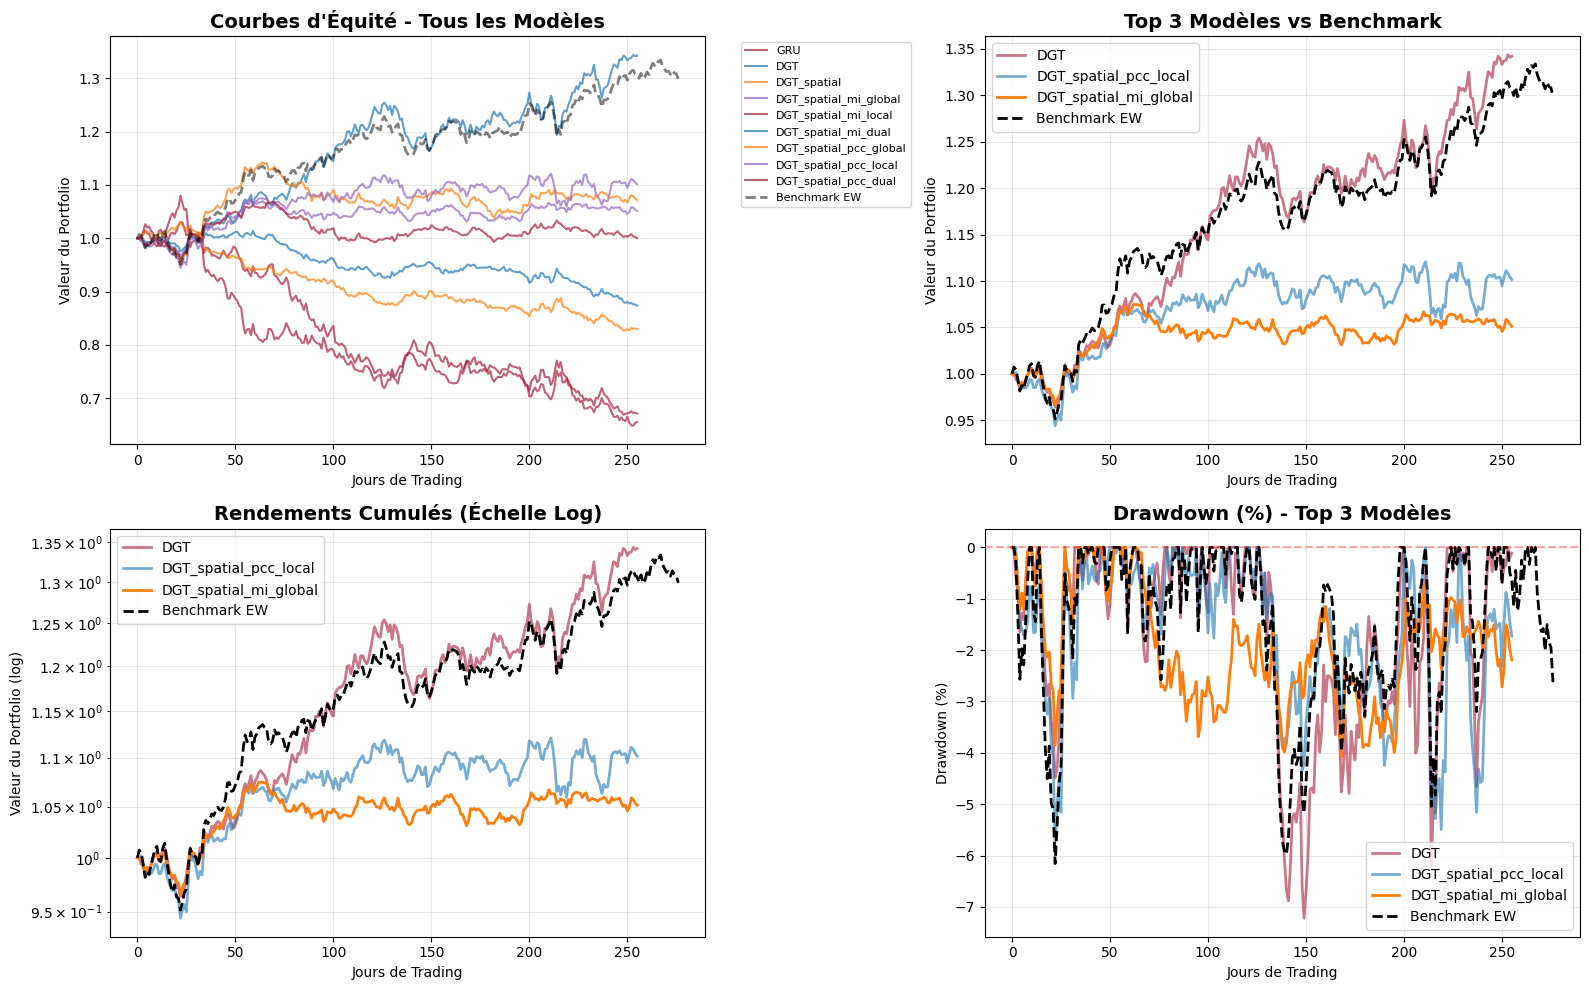

📈 Graphiques sauvegardés dans: benchmark_comparison.png


In [52]:
# Graphique comparatif des courbes d'équité
plt.figure(figsize=(16, 10))

# Calculer le benchmark Equal Weight
df_raw = pd.read_csv(f'{workdir}/sp500.csv').set_index('Date')
num_quarters = len(df_raw) // days_in_quarter
test_start = int(0.9 * num_quarters) * days_in_quarter
test_data = df_raw.iloc[test_start:]
ew_returns = test_data.pct_change().mean(axis=1).fillna(0)
ew_equity = (1 + ew_returns).cumprod()

# Plot 1: Toutes les courbes ensemble
plt.subplot(2, 2, 1)
for model_name, data in benchmark_results.items():
    equity = data['metrics']['equity_curve']
    plt.plot(equity.values, label=model_name, alpha=0.7, linewidth=1.5)
plt.plot(ew_equity.values, label='Benchmark EW', linestyle='--', color='black', linewidth=2, alpha=0.5)
plt.title('Courbes d\'Équité - Tous les Modèles', fontsize=14, fontweight='bold')
plt.xlabel('Jours de Trading')
plt.ylabel('Valeur du Portfolio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)

# Plot 2: Top 3 modèles vs Benchmark
plt.subplot(2, 2, 2)
top_3 = df_comparison.head(3)['Model'].tolist()
for model_name in top_3:
    equity = benchmark_results[model_name]['metrics']['equity_curve']
    plt.plot(equity.values, label=model_name, linewidth=2)
plt.plot(ew_equity.values, label='Benchmark EW', linestyle='--', color='black', linewidth=2)
plt.title('Top 3 Modèles vs Benchmark', fontsize=14, fontweight='bold')
plt.xlabel('Jours de Trading')
plt.ylabel('Valeur du Portfolio')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Plot 3: Rendements cumulés (log scale)
plt.subplot(2, 2, 3)
for model_name in top_3:
    equity = benchmark_results[model_name]['metrics']['equity_curve']
    plt.semilogy(equity.values, label=model_name, linewidth=2)
plt.semilogy(ew_equity.values, label='Benchmark EW', linestyle='--', color='black', linewidth=2)
plt.title('Rendements Cumulés (Échelle Log)', fontsize=14, fontweight='bold')
plt.xlabel('Jours de Trading')
plt.ylabel('Valeur du Portfolio (log)')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which="both")

# Plot 4: Drawdowns des top 3
plt.subplot(2, 2, 4)
for model_name in top_3:
    equity = benchmark_results[model_name]['metrics']['equity_curve']
    drawdown = (equity - equity.cummax()) / equity.cummax()
    plt.plot(drawdown.values * 100, label=model_name, linewidth=2)
ew_drawdown = (ew_equity - ew_equity.cummax()) / ew_equity.cummax()
plt.plot(ew_drawdown.values * 100, label='Benchmark EW', linestyle='--', color='black', linewidth=2)
plt.title('Drawdown (%) - Top 3 Modèles', fontsize=14, fontweight='bold')
plt.xlabel('Jours de Trading')
plt.ylabel('Drawdown (%)')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{workdir}/benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("📈 Graphiques sauvegardés dans: benchmark_comparison.png")

## Comparaison des Métriques Clés (Graphiques en Barres)

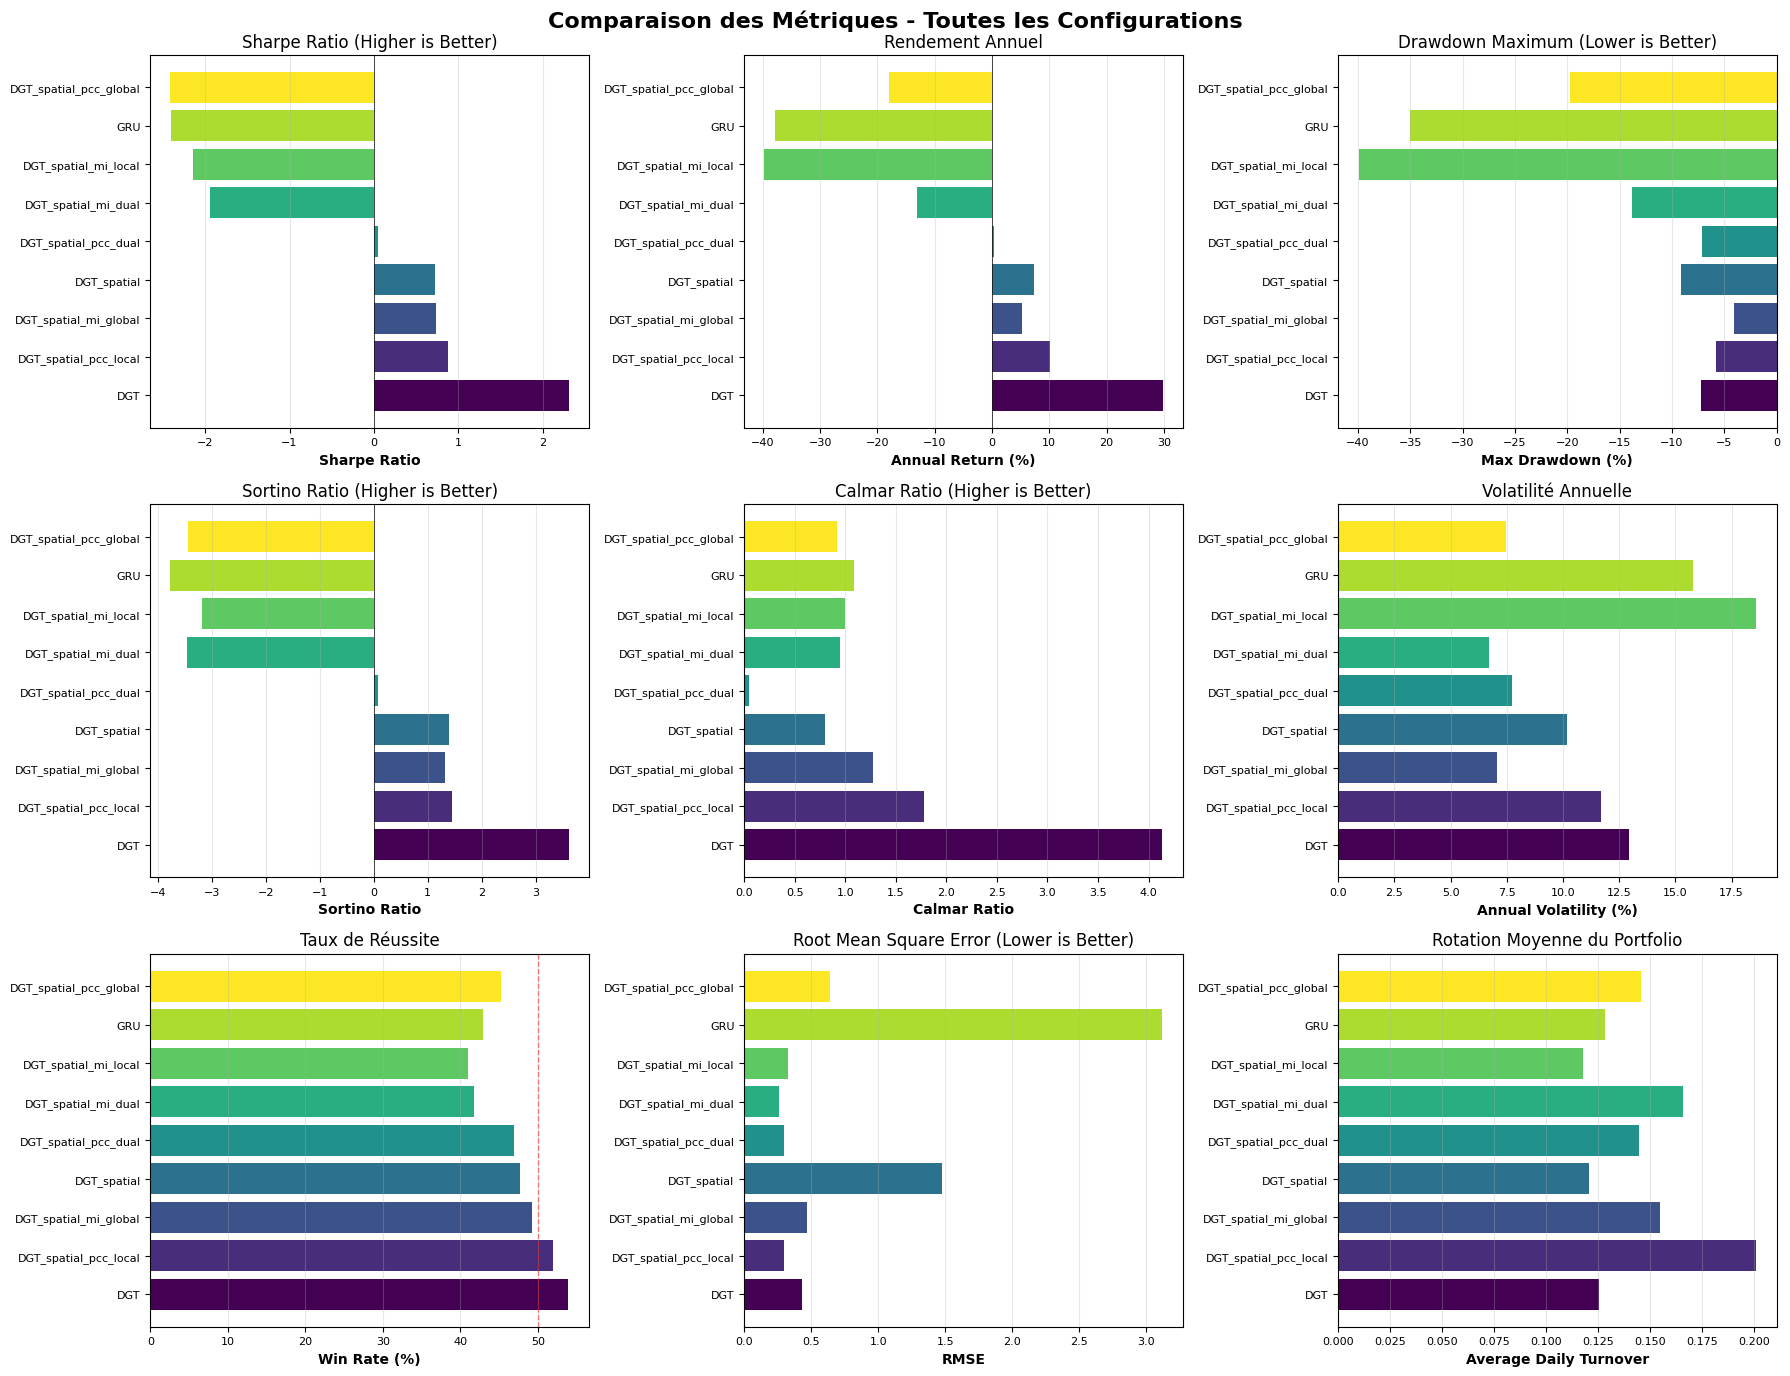

📊 Graphiques sauvegardés dans: benchmark_metrics_bars.png


In [53]:
# Graphiques en barres pour les métriques clés
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Comparaison des Métriques - Toutes les Configurations', fontsize=16, fontweight='bold')

models = df_comparison['Model'].tolist()
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

# 1. Sharpe Ratio
ax = axes[0, 0]
sharpe_values = [benchmark_results[m]['metrics']['sharpe'] for m in models]
bars = ax.barh(models, sharpe_values, color=colors)
ax.set_xlabel('Sharpe Ratio', fontweight='bold')
ax.set_title('Sharpe Ratio (Higher is Better)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 2. Annual Return
ax = axes[0, 1]
returns = [benchmark_results[m]['metrics']['ann_return'] * 100 for m in models]
ax.barh(models, returns, color=colors)
ax.set_xlabel('Annual Return (%)', fontweight='bold')
ax.set_title('Rendement Annuel')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 3. Max Drawdown
ax = axes[0, 2]
dd_values = [benchmark_results[m]['metrics']['max_dd'] * 100 for m in models]
ax.barh(models, dd_values, color=colors)
ax.set_xlabel('Max Drawdown (%)', fontweight='bold')
ax.set_title('Drawdown Maximum (Lower is Better)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 4. Sortino Ratio
ax = axes[1, 0]
sortino_values = [benchmark_results[m]['metrics']['sortino'] for m in models]
ax.barh(models, sortino_values, color=colors)
ax.set_xlabel('Sortino Ratio', fontweight='bold')
ax.set_title('Sortino Ratio (Higher is Better)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 5. Calmar Ratio
ax = axes[1, 1]
calmar_values = [benchmark_results[m]['metrics']['calmar'] for m in models]
ax.barh(models, calmar_values, color=colors)
ax.set_xlabel('Calmar Ratio', fontweight='bold')
ax.set_title('Calmar Ratio (Higher is Better)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 6. Annual Volatility
ax = axes[1, 2]
vol_values = [benchmark_results[m]['metrics']['ann_vol'] * 100 for m in models]
ax.barh(models, vol_values, color=colors)
ax.set_xlabel('Annual Volatility (%)', fontweight='bold')
ax.set_title('Volatilité Annuelle')
ax.grid(True, alpha=0.3, axis='x')

# 7. Win Rate
ax = axes[2, 0]
win_rate_values = [benchmark_results[m]['metrics']['win_rate'] * 100 for m in models]
ax.barh(models, win_rate_values, color=colors)
ax.set_xlabel('Win Rate (%)', fontweight='bold')
ax.set_title('Taux de Réussite')
ax.axvline(x=50, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')

# 8. RMSE (Prediction Error)
ax = axes[2, 1]
rmse_values = [benchmark_results[m]['rmse'] for m in models]
ax.barh(models, rmse_values, color=colors)
ax.set_xlabel('RMSE', fontweight='bold')
ax.set_title('Root Mean Square Error (Lower is Better)')
ax.grid(True, alpha=0.3, axis='x')

# 9. Average Turnover
ax = axes[2, 2]
turnover_values = [benchmark_results[m]['metrics']['avg_turnover'] for m in models]
ax.barh(models, turnover_values, color=colors)
ax.set_xlabel('Average Daily Turnover', fontweight='bold')
ax.set_title('Rotation Moyenne du Portfolio')
ax.grid(True, alpha=0.3, axis='x')

# Ajuster les tailles de police
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=8)
    
plt.tight_layout()
plt.savefig(f'{workdir}/benchmark_metrics_bars.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Graphiques sauvegardés dans: benchmark_metrics_bars.png")

## Analyse Risk-Adjusted Performance: Scatter Plots

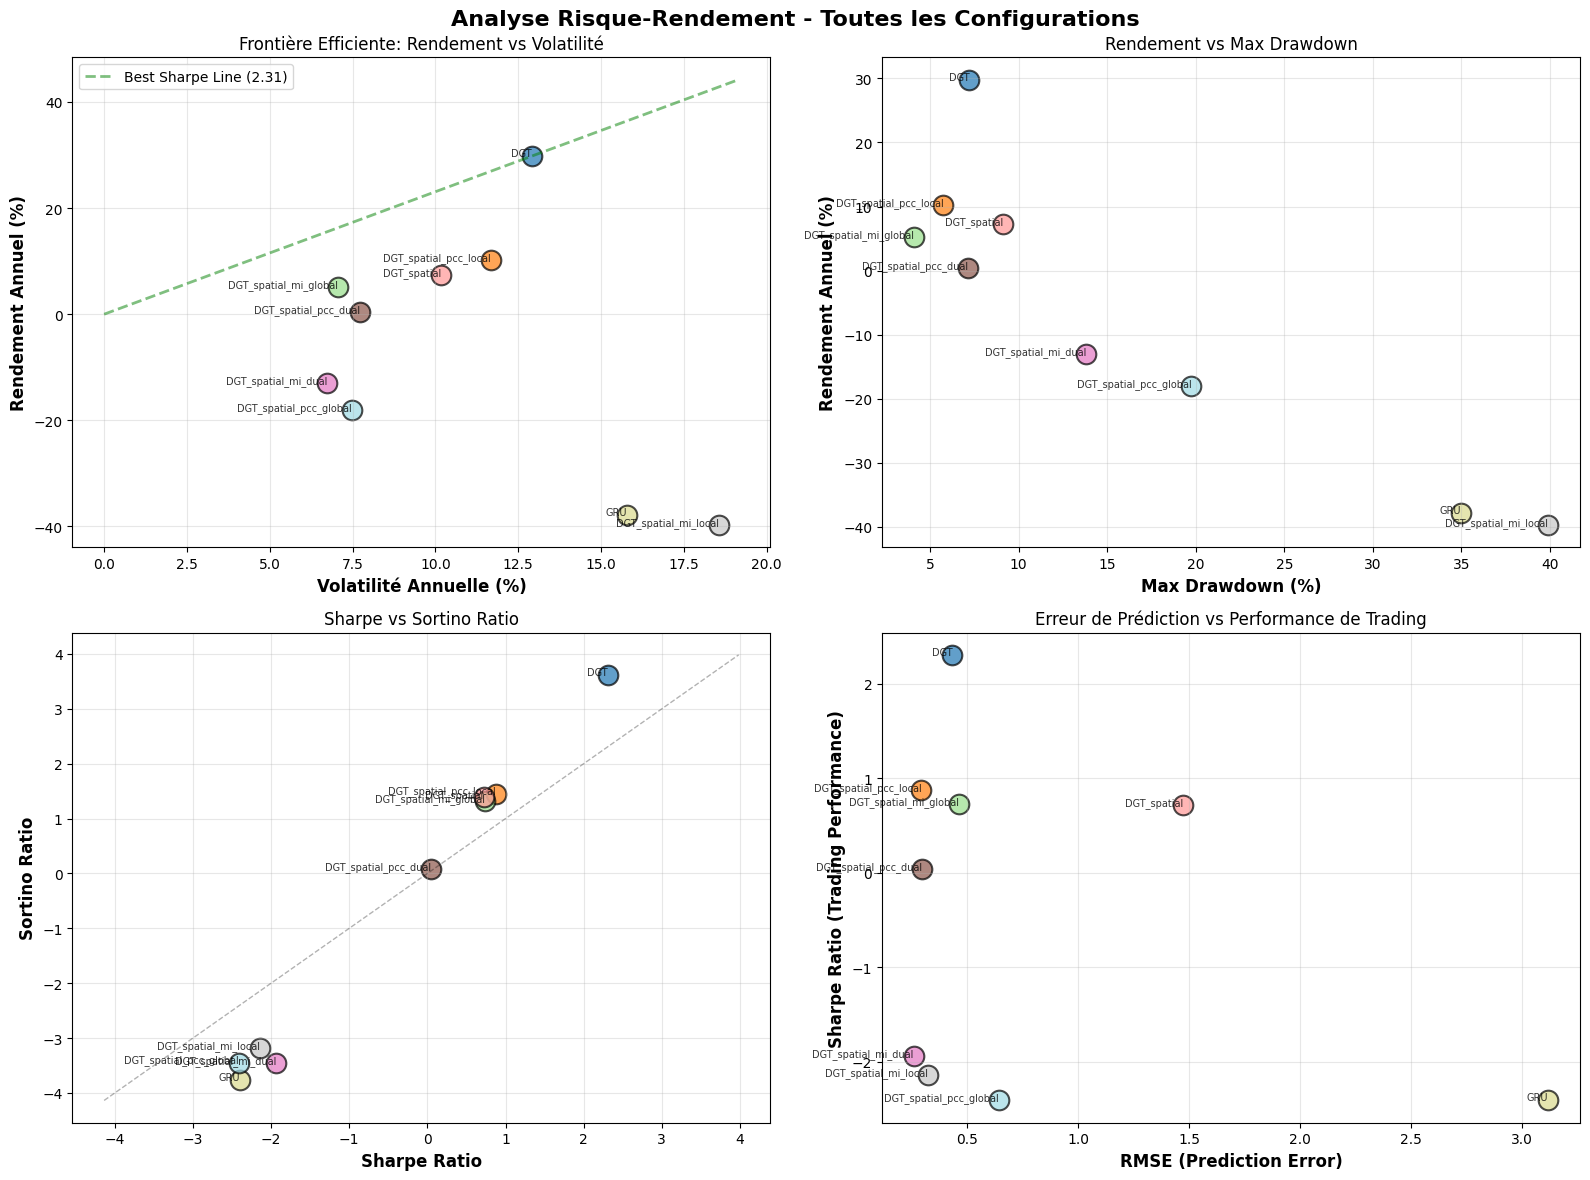

📉 Graphiques sauvegardés dans: benchmark_risk_analysis.png


In [54]:
# Scatter plots pour l'analyse risque-rendement
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse Risque-Rendement - Toutes les Configurations', fontsize=16, fontweight='bold')

models = df_comparison['Model'].tolist()
colors_scatter = plt.cm.tab20(np.linspace(0, 1, len(models)))

# 1. Return vs Volatility (Efficient Frontier)
ax = axes[0, 0]
for i, model_name in enumerate(models):
    metrics = benchmark_results[model_name]['metrics']
    ax.scatter(metrics['ann_vol'] * 100, metrics['ann_return'] * 100, 
               s=200, alpha=0.7, color=colors_scatter[i], edgecolors='black', linewidth=1.5)
    ax.annotate(model_name, (metrics['ann_vol'] * 100, metrics['ann_return'] * 100),
                fontsize=7, ha='right', alpha=0.8)

# Ligne de Capital Market
best_sharpe_model = df_comparison.iloc[0]['Model']
best_sharpe_val = benchmark_results[best_sharpe_model]['metrics']['sharpe']
x_line = np.linspace(0, ax.get_xlim()[1], 100)
y_line = best_sharpe_val * x_line
ax.plot(x_line, y_line, 'g--', alpha=0.5, linewidth=2, label=f'Best Sharpe Line ({best_sharpe_val:.2f})')

ax.set_xlabel('Volatilité Annuelle (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Rendement Annuel (%)', fontweight='bold', fontsize=12)
ax.set_title('Frontière Efficiente: Rendement vs Volatilité')
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Return vs Max Drawdown
ax = axes[0, 1]
for i, model_name in enumerate(models):
    metrics = benchmark_results[model_name]['metrics']
    ax.scatter(abs(metrics['max_dd']) * 100, metrics['ann_return'] * 100,
               s=200, alpha=0.7, color=colors_scatter[i], edgecolors='black', linewidth=1.5)
    ax.annotate(model_name, (abs(metrics['max_dd']) * 100, metrics['ann_return'] * 100),
                fontsize=7, ha='right', alpha=0.8)

ax.set_xlabel('Max Drawdown (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Rendement Annuel (%)', fontweight='bold', fontsize=12)
ax.set_title('Rendement vs Max Drawdown')
ax.grid(True, alpha=0.3)

# 3. Sharpe vs Sortino
ax = axes[1, 0]
for i, model_name in enumerate(models):
    metrics = benchmark_results[model_name]['metrics']
    ax.scatter(metrics['sharpe'], metrics['sortino'],
               s=200, alpha=0.7, color=colors_scatter[i], edgecolors='black', linewidth=1.5,
               label=model_name)
    ax.annotate(model_name, (metrics['sharpe'], metrics['sortino']),
                fontsize=7, ha='right', alpha=0.8)

# Ligne diagonale de référence
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, linewidth=1)

ax.set_xlabel('Sharpe Ratio', fontweight='bold', fontsize=12)
ax.set_ylabel('Sortino Ratio', fontweight='bold', fontsize=12)
ax.set_title('Sharpe vs Sortino Ratio')
ax.grid(True, alpha=0.3)

# 4. RMSE vs Sharpe Ratio (Prediction vs Trading Performance)
ax = axes[1, 1]
for i, model_name in enumerate(models):
    rmse = benchmark_results[model_name]['rmse']
    sharpe = benchmark_results[model_name]['metrics']['sharpe']
    ax.scatter(rmse, sharpe,
               s=200, alpha=0.7, color=colors_scatter[i], edgecolors='black', linewidth=1.5)
    ax.annotate(model_name, (rmse, sharpe),
                fontsize=7, ha='right', alpha=0.8)

ax.set_xlabel('RMSE (Prediction Error)', fontweight='bold', fontsize=12)
ax.set_ylabel('Sharpe Ratio (Trading Performance)', fontweight='bold', fontsize=12)
ax.set_title('Erreur de Prédiction vs Performance de Trading')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{workdir}/benchmark_risk_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("📉 Graphiques sauvegardés dans: benchmark_risk_analysis.png")

## Analyse par Type de Modèle et Corrélation

In [55]:
# Analyse détaillée par type de modèle
print("\n" + "="*80)
print("📊 ANALYSE PAR TYPE DE MODÈLE")
print("="*80)

# Grouper par architecture
gru_models = [m for m in models if 'GRU' in m]
dgt_no_spatial = [m for m in models if 'DGT' in m and 'spatial' not in m]
dgt_spatial = [m for m in models if 'DGT_spatial' in m]

print("\n🔹 GRU Baseline:")
for model_name in gru_models:
    metrics = benchmark_results[model_name]['metrics']
    print(f"  {model_name}: Sharpe={metrics['sharpe']:.3f}, Return={metrics['ann_return']:.2%}, DD={metrics['max_dd']:.2%}")

print("\n🔹 DGT sans Spatial Attention:")
for model_name in dgt_no_spatial:
    metrics = benchmark_results[model_name]['metrics']
    print(f"  {model_name}: Sharpe={metrics['sharpe']:.3f}, Return={metrics['ann_return']:.2%}, DD={metrics['max_dd']:.2%}")

print("\n🔹 DGT avec Spatial Attention:")
mi_models = [m for m in dgt_spatial if 'mi' in m]
pcc_models = [m for m in dgt_spatial if 'pcc' in m]

print("\n  📈 Avec Mutual Information:")
for model_name in mi_models:
    metrics = benchmark_results[model_name]['metrics']
    print(f"    {model_name}: Sharpe={metrics['sharpe']:.3f}, Return={metrics['ann_return']:.2%}, DD={metrics['max_dd']:.2%}")

print("\n  📈 Avec Pearson Correlation:")
for model_name in pcc_models:
    metrics = benchmark_results[model_name]['metrics']
    print(f"    {model_name}: Sharpe={metrics['sharpe']:.3f}, Return={metrics['ann_return']:.2%}, DD={metrics['max_dd']:.2%}")

# Statistiques par groupe
print("\n" + "="*80)
print("📊 STATISTIQUES MOYENNES PAR GROUPE")
print("="*80)

def calc_group_stats(model_list):
    if not model_list:
        return None
    sharpes = [benchmark_results[m]['metrics']['sharpe'] for m in model_list]
    returns = [benchmark_results[m]['metrics']['ann_return'] for m in model_list]
    dds = [benchmark_results[m]['metrics']['max_dd'] for m in model_list]
    return {
        'avg_sharpe': np.mean(sharpes),
        'avg_return': np.mean(returns),
        'avg_dd': np.mean(dds),
        'count': len(model_list)
    }

groups = {
    'GRU Baseline': gru_models,
    'DGT No Spatial': dgt_no_spatial,
    'DGT + MI': mi_models,
    'DGT + PCC': pcc_models
}

for group_name, group_models in groups.items():
    stats = calc_group_stats(group_models)
    if stats:
        print(f"\n{group_name} ({stats['count']} modèles):")
        print(f"  Sharpe Moyen: {stats['avg_sharpe']:.3f}")
        print(f"  Return Moyen: {stats['avg_return']:.2%}")
        print(f"  Max DD Moyen: {stats['avg_dd']:.2%}")


📊 ANALYSE PAR TYPE DE MODÈLE

🔹 GRU Baseline:
  GRU: Sharpe=-2.402, Return=-37.92%, DD=-34.99%

🔹 DGT sans Spatial Attention:
  DGT: Sharpe=2.308, Return=29.82%, DD=-7.22%

🔹 DGT avec Spatial Attention:

  📈 Avec Mutual Information:
    DGT_spatial_mi_global: Sharpe=0.733, Return=5.17%, DD=-4.07%
    DGT_spatial_mi_dual: Sharpe=-1.938, Return=-13.04%, DD=-13.82%
    DGT_spatial_mi_local: Sharpe=-2.142, Return=-39.77%, DD=-39.90%

  📈 Avec Pearson Correlation:
    DGT_spatial_pcc_local: Sharpe=0.872, Return=10.19%, DD=-5.74%
    DGT_spatial_pcc_dual: Sharpe=0.042, Return=0.32%, DD=-7.13%
    DGT_spatial_pcc_global: Sharpe=-2.411, Return=-18.04%, DD=-19.75%

📊 STATISTIQUES MOYENNES PAR GROUPE

GRU Baseline (1 modèles):
  Sharpe Moyen: -2.402
  Return Moyen: -37.92%
  Max DD Moyen: -34.99%

DGT No Spatial (1 modèles):
  Sharpe Moyen: 2.308
  Return Moyen: 29.82%
  Max DD Moyen: -7.22%

DGT + MI (3 modèles):
  Sharpe Moyen: -1.116
  Return Moyen: -15.88%
  Max DD Moyen: -19.26%

DGT + PCC

## Comparaison des Corrélations: MI vs PCC

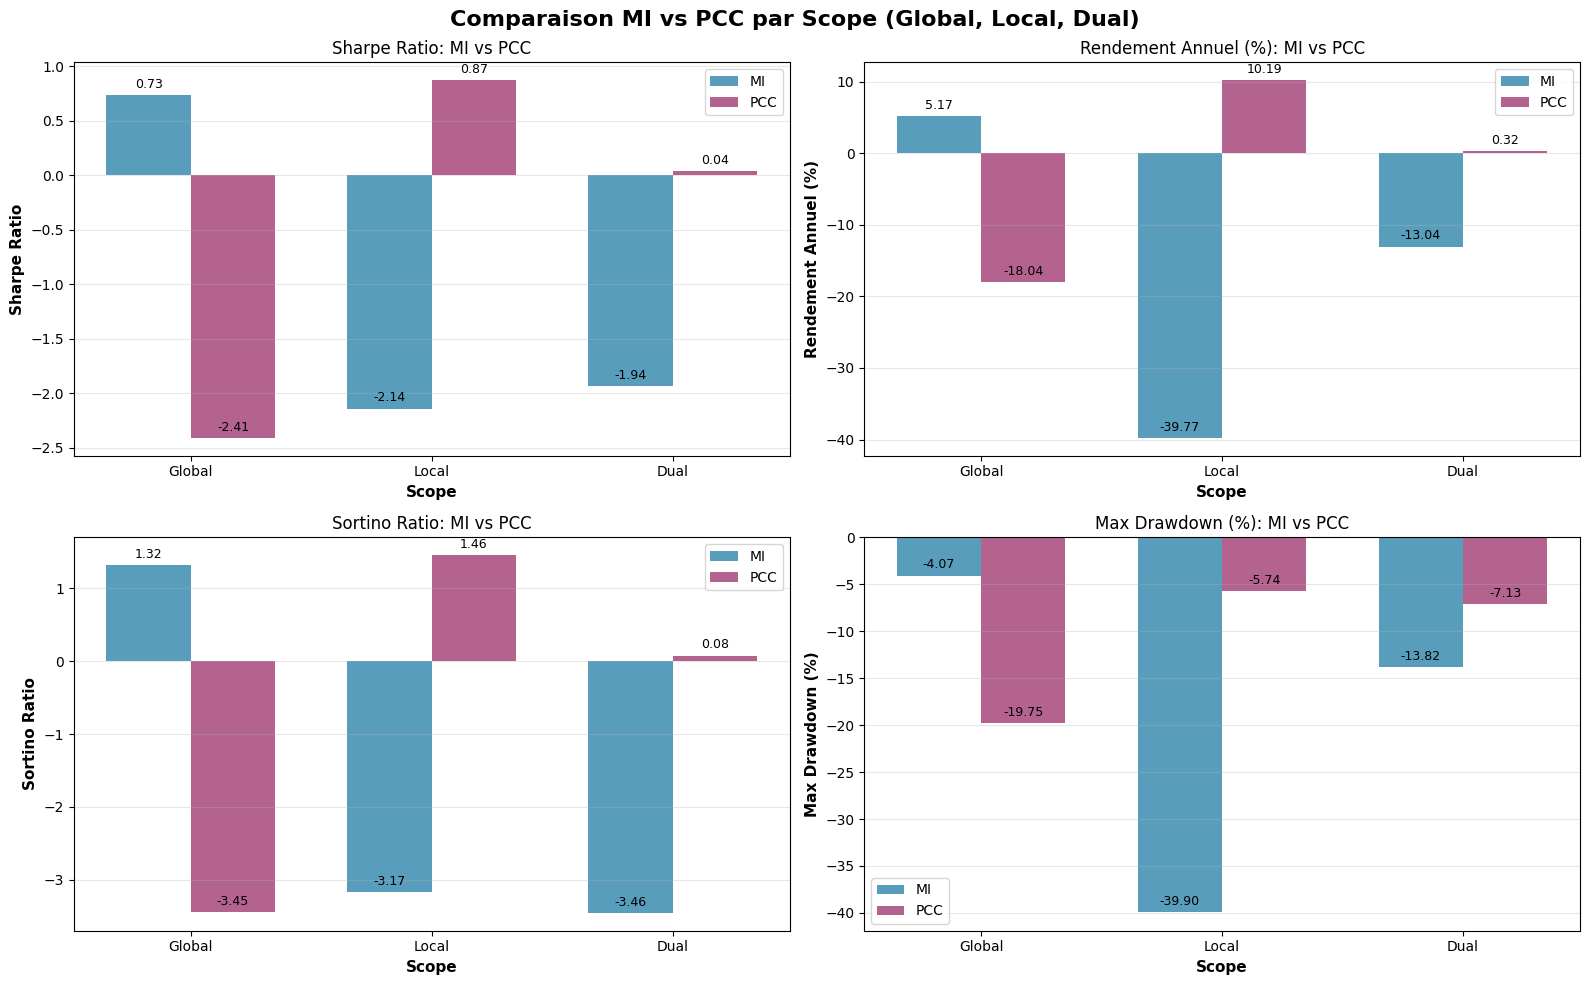

📊 Comparaison MI vs PCC sauvegardée dans: benchmark_mi_vs_pcc.png

🔍 ANALYSE: MUTUAL INFORMATION vs PEARSON CORRELATION

GLOBAL:
  MI Sharpe:  0.733
  PCC Sharpe: -2.411
  🏆 Winner: MI (+3.144)

LOCAL:
  MI Sharpe:  -2.142
  PCC Sharpe: 0.872
  🏆 Winner: PCC (+3.014)

DUAL:
  MI Sharpe:  -1.938
  PCC Sharpe: 0.042
  🏆 Winner: PCC (+1.980)


In [56]:
# Graphique comparatif MI vs PCC par scope
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Comparaison MI vs PCC par Scope (Global, Local, Dual)', fontsize=16, fontweight='bold')

scopes = ['global', 'local', 'dual']
metrics_to_compare = ['sharpe', 'ann_return', 'sortino', 'max_dd']
metric_labels = ['Sharpe Ratio', 'Rendement Annuel (%)', 'Sortino Ratio', 'Max Drawdown (%)']

for idx, (metric, label) in enumerate(zip(metrics_to_compare, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    mi_values = []
    pcc_values = []
    
    for scope in scopes:
        mi_model = f"DGT_spatial_mi_{scope}"
        pcc_model = f"DGT_spatial_pcc_{scope}"
        
        if mi_model in benchmark_results:
            val = benchmark_results[mi_model]['metrics'][metric]
            if metric in ['ann_return', 'max_dd']:
                val *= 100
            mi_values.append(val)
        else:
            mi_values.append(0)
            
        if pcc_model in benchmark_results:
            val = benchmark_results[pcc_model]['metrics'][metric]
            if metric in ['ann_return', 'max_dd']:
                val *= 100
            pcc_values.append(val)
        else:
            pcc_values.append(0)
    
    x = np.arange(len(scopes))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, mi_values, width, label='MI', alpha=0.8, color='#2E86AB')
    bars2 = ax.bar(x + width/2, pcc_values, width, label='PCC', alpha=0.8, color='#A23B72')
    
    ax.set_xlabel('Scope', fontweight='bold', fontsize=11)
    ax.set_ylabel(label, fontweight='bold', fontsize=11)
    ax.set_title(f'{label}: MI vs PCC')
    ax.set_xticks(x)
    ax.set_xticklabels(['Global', 'Local', 'Dual'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs sur les barres
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{workdir}/benchmark_mi_vs_pcc.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Comparaison MI vs PCC sauvegardée dans: benchmark_mi_vs_pcc.png")

# Résumé textuel
print("\n" + "="*80)
print("🔍 ANALYSE: MUTUAL INFORMATION vs PEARSON CORRELATION")
print("="*80)

for scope in scopes:
    mi_model = f"DGT_spatial_mi_{scope}"
    pcc_model = f"DGT_spatial_pcc_{scope}"
    
    if mi_model in benchmark_results and pcc_model in benchmark_results:
        mi_sharpe = benchmark_results[mi_model]['metrics']['sharpe']
        pcc_sharpe = benchmark_results[pcc_model]['metrics']['sharpe']
        
        winner = "MI" if mi_sharpe > pcc_sharpe else "PCC"
        diff = abs(mi_sharpe - pcc_sharpe)
        
        print(f"\n{scope.upper()}:")
        print(f"  MI Sharpe:  {mi_sharpe:.3f}")
        print(f"  PCC Sharpe: {pcc_sharpe:.3f}")
        print(f"  🏆 Winner: {winner} (+{diff:.3f})")